In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
from skimage.transform import resize
import os

# Set paths to the images and masks
image_dir = 'N:\\My Drive\\Data\\RUH'
mask_dir = 'N:\\My Drive\\Data\\Mask'
# List of image and mask files
image_files = sorted(os.listdir(image_dir))[:33000]
mask_files = sorted(os.listdir(mask_dir))[:33000]

# Function to normalize images and encode masks
def prepare_data(img_path, mask_path):
    # Read the image and mask files
    img = imread(img_path) / 255.0  # Normalize to [0, 1]
    mask = imread(mask_path, as_gray=True)  # Read mask as grayscale
    # Resize images and masks if not already 256x256
    if img.shape[0] != 256 or img.shape[1] != 256:
        img = resize(img, (256, 256), anti_aliasing=True)
    if mask.shape[0] != 256 or mask.shape[1] != 256:
        mask = resize(mask, (256, 256), order=0, preserve_range=True)
    # Map mask pixel values to class labels
    mask[mask == 255] = 3
    mask[mask == 170] = 2
    mask[mask == 85] = 1
    mask[mask == 0] = 0
    # Convert mask to categorical
    mask = to_categorical(mask, num_classes=4)
    return img, mask

# Generator to load images in batches
def generate_batches(image_files, mask_files, batch_size):
    num_samples = len(image_files)
    while True:  # Loop indefinitely
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            images, masks = [], []
            for i in range(start, end):
                img_path = os.path.join(image_dir, image_files[i])
                mask_path = os.path.join(mask_dir, mask_files[i])
                img, mask = prepare_data(img_path, mask_path)
                images.append(img)
                masks.append(mask)
            yield np.array(images), np.array(masks)



In [2]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets
image_files_train, image_files_val, mask_files_train, mask_files_val = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32

# Training and validation generator
train_generator = generate_batches(image_files_train, mask_files_train, batch_size)
val_generator = generate_batches(image_files_val, mask_files_val, batch_size)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
unet = unet_model()

# Display the model architecture
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,962,676 (7.49 MB)

 Trainable params: 1,962,676 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for saving the model and early stopping
model_checkpoint = ModelCheckpoint('unet_segmentation_2.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = unet.fit(
    x=train_generator,
    y=None,  # Since the generator yields both images and masks, y is not separately provided
    batch_size=None,  # Batch size is handled by the generator
    epochs=30,
    steps_per_epoch=int(np.ceil(len(image_files_train) / batch_size)),  # Convert to int
    validation_data=val_generator,
    validation_steps=int(np.ceil(len(image_files_val) / batch_size)),  # Convert to int
    callbacks=[model_checkpoint, early_stopping]
)


Epoch 1/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 2030s 2s/step - accuracy: 0.7498 - loss: 0.5027 - val_accuracy: 0.9407 - val_loss: 0.1827
Epoch 2/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 2036s 2s/step - accuracy: 0.9420 - loss: 0.1729 - val_accuracy: 0.9434 - val_loss: 0.1655
Epoch 3/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 7141s 9s/step - accuracy: 0.9464 - loss: 0.1556 - val_accuracy: 0.9400 - val_loss: 0.1623
Epoch 4/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 2017s 2s/step - accuracy: 0.9500 - loss: 0.1434 - val_accuracy: 0.9492 - val_loss: 0.1399
Epoch 5/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 5113s 6s/step - accuracy: 0.9524 - loss: 0.1353 - val_accuracy: 0.9529 - val_loss: 0.1303
Epoch 6/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 2030s 2s/step - accuracy: 0.9543 - loss: 0.1291 - val_accuracy: 0.9539 - val_loss: 0.1273
Epoch 7/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 2001s 2s/step - accuracy: 0.9558 - loss: 0.1240 - val_accuracy: 0.9559 - val_loss: 0.1218
Epoch 8/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 1975s 2s/step - accuracy: 0.9571 - loss: 0.1197 - 

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [Errno 22] Invalid argument
Traceback (most recent call last):

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator:

  File "C:\Users\Musae\AppData\Local\Temp\ipykernel_20020\2675741353.py", line 44, in generate_batches
    img, mask = prepare_data(img_path, mask_path)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Musae\AppData\Local\Temp\ipykernel_20020\2675741353.py", line 18, in prepare_data
    img = imread(img_path) / 255.0  # Normalize to [0, 1]
          ^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_io.py", line 60, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\manage_plugins.py", line 217, in call_plugin
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_plugins\imageio_plugin.py", line 11, in imread
    out = np.asarray(imageio_imread(*args, **kwargs))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\imageio\v3.py", line 54, in imread
    return np.asarray(img_file.read(**call_kwargs))
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\imageio\plugins\pillow.py", line 252, in read
    image = self._apply_transforms(
            ^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\imageio\plugins\pillow.py", line 333, in _apply_transforms
    image = np.asarray(image)
            ^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py", line 673, in __array_interface__
    new["data"] = self.tobytes()
                  ^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py", line 732, in tobytes
    self.load()

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\ImageFile.py", line 249, in load
    s = read(self.decodermaxblock)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\PngImagePlugin.py", line 952, in load_read
    return self.fp.read(read_bytes)
           ^^^^^^^^^^^^^^^^^^^^^^^^

OSError: [Errno 22] Invalid argument


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_7850]

NameError: name 'history' is not defined

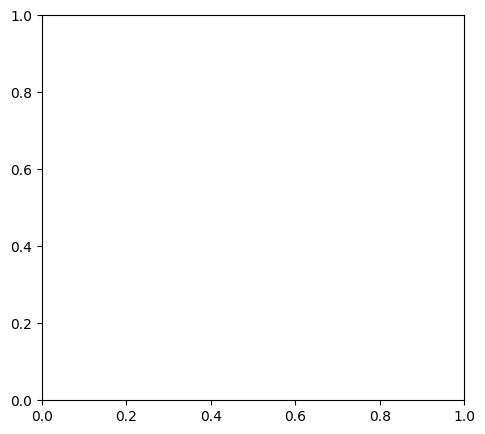

In [10]:

# Optional: Plot training history for loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
from tensorflow.keras.models import load_model

# Load the trained model from file
model = load_model('unet_segmentation_2.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


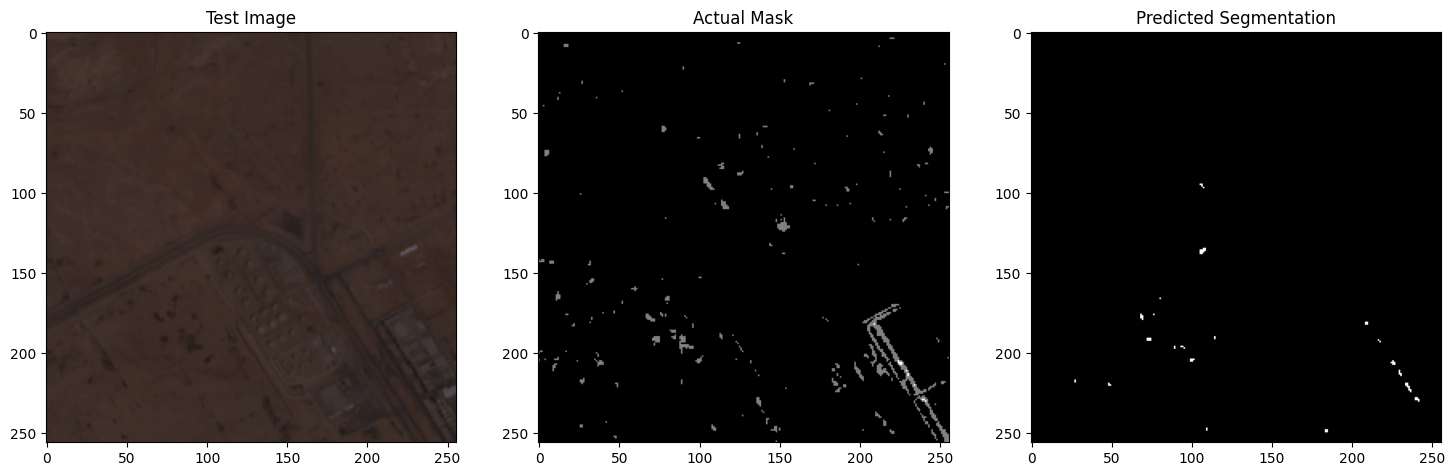

In [9]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt

# Correct path to the single image file
test_image_path = "N:\\My Drive\\Data\\RUH\\RGB_RUH-All-Bands_2019-04-14_sub_60.png"
mask_image_path = "N:\\My Drive\\Data\\Mask\\MASK_RUH-All-Bands_2019-04-14_sub_60.png"

# Function to prepare and load the image
def prepare_image(file_path):
    img = imread(file_path)
    img = img / 255.0  # Normalize the image to [0, 1]
    if img.shape != (256, 256, 3):  # Check if resizing is needed
        img = resize(img, (256, 256), anti_aliasing=True)
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input
    return img

# Load the actual mask
actual_mask = imread(mask_image_path)
if actual_mask.shape != (256, 256):  # Resize if not already 256x256
    actual_mask = resize(actual_mask, (256, 256), anti_aliasing=True)

# Load and prepare the test image
test_image = prepare_image(test_image_path)

# Predict using the model
predicted_mask = model.predict(test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert probabilities to class labels

# Display the image, actual mask, and predicted segmentation
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(actual_mask, cmap='gray')
plt.title('Actual Mask')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask[0]), cmap='gray')
plt.title('Predicted Segmentation')
plt.show()

